This notebook contains the remaining preprocessing functions that must be applied to the sea and seism data before training any machine learning models, in line with Minio et al.'s code.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy import stats
from obspy.core.utcdatetime import UTCDateTime

from obspy.geodetics import gps2dist_azimuth

# Clean Sea Data

In [2]:
#Load data from parquet files

path_lat = "Processed Data/SEA_data_lat.parquet"
path_lon = "Processed Data/SEA_data_lon.parquet"
path_Y = "Processed Data/SEA_data_Y.parquet"
path_time = "Processed Data/SEA_data_time.parquet"

df_lat = pd.read_parquet(path_lat)
df_lon = pd.read_parquet(path_lon)
df_Y = pd.read_parquet(path_Y)
df_time = pd.read_parquet(path_time)

In [3]:
print(df_Y.shape)

(35064, 9964)


In [4]:
#Find latitudes and longitudes for which there is no sea data (columns of nans)

nan_columns = df_Y.columns[df_Y.isna().all()]

num_lat = df_lat.shape[0]
num_lon = df_lon.shape[1]

nan_lat_lon = []

for col_index in nan_columns:
    lat_index = num_lat - 1 - (col_index // num_lon) #get row index (latitude). -1 ensures correct alignment with map
    lon_index = col_index % num_lon #get column index (longitude)

    latitude = df_lat.iloc[lat_index, lon_index]
    longitude = df_lon.iloc[lat_index, lon_index]

    nan_lat_lon.append((latitude, longitude))

print(len(nan_lat_lon))

1609


C:\Users\erika\AppData\Local\Temp\ipykernel_17760\3927807446.py:11: RuntimeWarning: Mean of empty slice
  Y_avg = np.nanmean(Y, axis=0)


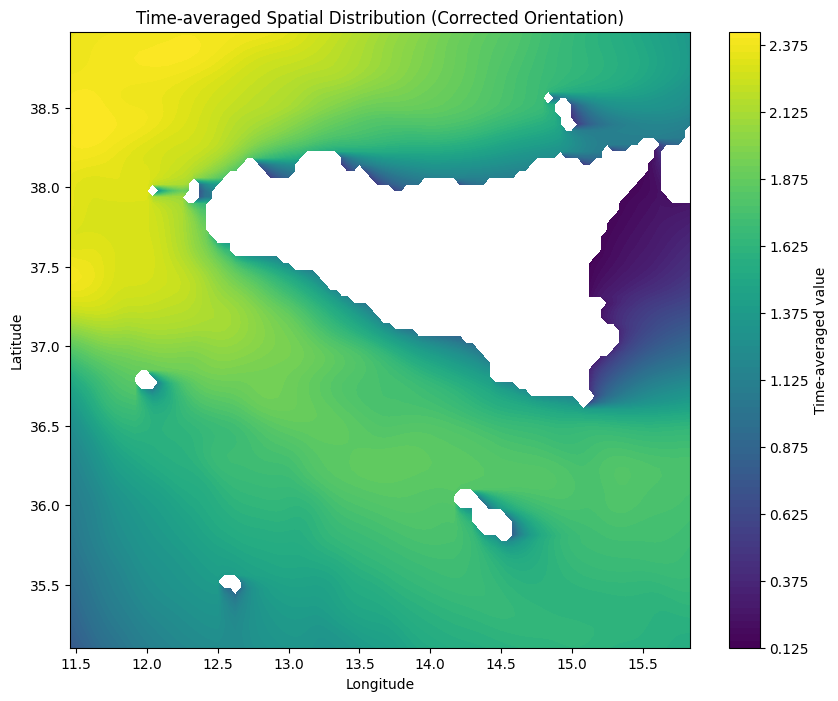

In [5]:
#Visualise 1 day of data on a map
Y = df_Y[0:24]
lat = np.array(df_lat).squeeze()
lon = np.array(df_lon).squeeze()

#Extract unique latitude and longitude values from the 2D arrays
lat = np.unique(lat[:, 0]) #Use the first column to extract unique latitudes
lon = np.unique(lon[0, :]) #Use the first row to extract unique longitudes

#Compute time-averaged data. ignoring nans. result of a whole column of nans is nan
Y_avg = np.nanmean(Y, axis=0)
Y_avg_reshaped = Y_avg.reshape(len(lat), len(lon))

#Create the heatmap
plt.figure(figsize=(10, 8))
plt.contourf(lon, lat, Y_avg_reshaped, levels=100, cmap='viridis')
plt.colorbar(label='Time-averaged value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Time-averaged Spatial Distribution (Corrected Orientation)')
plt.show()

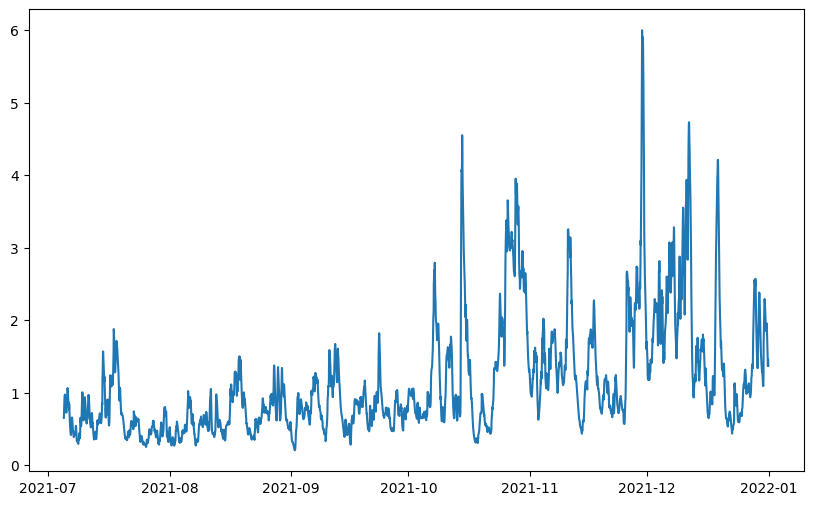

In [6]:
#Visualise 2021 H2 data to see impact of Apollo in October 2021

#get data of approx the last six months in the dataset hourly, for one location
Y_2021H2 = df_Y.iloc[-(6*30*24):,3600]

time_2021H2 = df_time.iloc[-(6*30*24):,0]

plt.figure(figsize=(10, 6))
plt.plot(time_2021H2, Y_2021H2, label='Y_2021H2')

In [7]:
#interpreting and unpacking the shape of the sea data

num_lat = df_lat.shape[0]
num_lon = df_lon.shape[1]

col_index = 3600

lat_index = col_index // num_lon #get row index (latitude)
lon_index = col_index % num_lon #get column index (longitude)

latitude = df_lat.iloc[lat_index, lon_index]
longitude = df_lon.iloc[lat_index, lon_index]
print(latitude,longitude)

37.604168 15.708336


In [8]:
#Combining the data such that it has format date, (lat,lon) in the header row for 7,632 lat and lon pairs and 35,064 rows.
# the data won't change much, the header row will - to include lat,lon
lat_unique = df_lat.iloc[:,0].values.flatten() #take the first column of df_lat to get the unique values
lat_unique = np.sort(lat_unique) #sort smallest to largest
lon_unique = df_lon.iloc[0,:].values.flatten() #take the first row of df_lon to get the unique values

In [9]:
#lat_unique

In [10]:
#lon_unique

In [11]:
lat_lon_pairs = []

for i in range(len(lat_unique)):
    for j in range(len(lon_unique)):
        lat_lon_pairs.append(f"({lat_unique[i]}, {lon_unique[j]})")

df_sea = pd.DataFrame(df_Y)

df_sea.columns = lat_lon_pairs

df_sea['time'] = df_time #add time
df_sea.set_index('time', inplace=True) #set it as index

In [12]:
df_sea.head()

(35.10416793823242, 11.458333969116211)  \
time                                                           
2018-01-01 00:00:00                                    0.637   
2018-01-01 01:00:00                                    0.637   
2018-01-01 02:00:00                                    0.623   
2018-01-01 03:00:00                                    0.602   
2018-01-01 04:00:00                                    0.567   

                     (35.10416793823242, 11.5)  \
time                                             
2018-01-01 00:00:00                      0.650   
2018-01-01 01:00:00                      0.655   
2018-01-01 02:00:00                      0.643   
2018-01-01 03:00:00                      0.623   
2018-01-01 04:00:00                      0.590   

                     (35.10416793823242, 11.541667938232422)  \
time                                                           
2018-01-01 00:00:00                                    0.665   
2018-01-01 01:00:00                                    0.671   
2018-01-01 02:00:00                                    0.663   
2018-01-01 03:00:00                                    0.645   
2018-01-01 04:00:00                                    0.613   

                     (35.10416793823242, 11.583333969116211)  \
time                                                           
2018-01-01 00:00:00                                    0.681   
2018-01-01 01:00:00                                    0.689   
2018-01-01 02:00:00                                    0.682   
2018-01-01 03:00:00                                    0.667   
2018-01-01 04:00:00                                    0.638   

                     (35.10416793823242, 11.625)  \
time                                               
2018-01-01 00:00:00                        0.694   
2018-01-01 01:00:00                        0.704   
2018-01-01 02:00:00                        0.699   
2018-01-01 03:00:00                        0.686   
2018-01-01 04:00:00                        0.660   

                     (35.10416793823242, 11.666667938232422)  \
time                                                           
2018-01-01 00:00:00                                    0.703   
2018-01-01 01:00:00                                    0.715   
2018-01-01 02:00:00                                    0.712   
2018-01-01 03:00:00                                    0.702   
2018-01-01 04:00:00                                    0.679   

                     (35.10416793823242, 11.708333969116211)  \
time                                                           
2018-01-01 00:00:00                                    0.708   
2018-01-01 01:00:00                                    0.722   
2018-01-01 02:00:00                                    0.720   
2018-01-01 03:00:00                                    0.712   
2018-01-01 04:00:00                                    0.692   

                     (35.10416793823242, 11.75)  \
time                                              
2018-01-01 00:00:00                       0.710   
2018-01-01 01:00:00                       0.724   
2018-01-01 02:00:00                       0.725   
2018-01-01 03:00:00                       0.719   
2018-01-01 04:00:00                       0.701   

                     (35.10416793823242, 11.791667938232422)  \
time                                                           
2018-01-01 00:00:00                                    0.711   
2018-01-01 01:00:00                                    0.726   
2018-01-01 02:00:00                                    0.728   
2018-01-01 03:00:00                                    0.724   
2018-01-01 04:00:00                                    0.708   

                     (35.10416793823242, 11.833333969116211)  ...  \
time                                                          ...   
2018-01-01 00:00:00                                    0.713  ...   
2018-01-01 01:00:00                           

In [13]:
df_sea.shape

(35064, 9964)

In [14]:
#dropping the data which corresponds to land (no wave data)

df_sea = df_sea.dropna(axis=1, how='all')
df_sea.shape

(35064, 8355)

# Load RMS Data

In [15]:
#Load data from parquet files

path_rms = "Processed Data/RMS_data.parquet"
df_rms = pd.read_parquet(path_rms)

# Plot all grid cells and all stations

In [16]:
#seismic Station names and coordinates - italian station locations taken from https://terremoti.ingv.it/en/instruments/network/IV
station_names = ['AIO', 'CAVT', 'CLTA', 'CSLB', 'HAGA', 'HPAC', 'MMGO', 'MPNC', 'MSDA', 'MSRU', 'MUCR', 'PZIN', 'SOLUN', 'WDD']
station_lats = [37.9712, 37.68, 37.16, 37.94, 37.29, 36.71, 37.66, 38.15, 35.901233, 38.26, 38.04, 36.81, 38.09, 35.837299]
station_lons = [15.233, 12.76, 13.96, 14.06, 15.16, 15.04, 12.98, 15.35, 14.486952, 15.51, 14.87, 11.97, 13.53, 14.5242]

In [17]:
#extract the latitudes and longitude pairs from the data
sea_data_pairs = df_sea.columns.tolist()

grid_lats = [float(pair.split(',')[0].strip('()')) for pair in sea_data_pairs]
grid_lons = [float(pair.split(',')[1].strip('()')) for pair in sea_data_pairs]

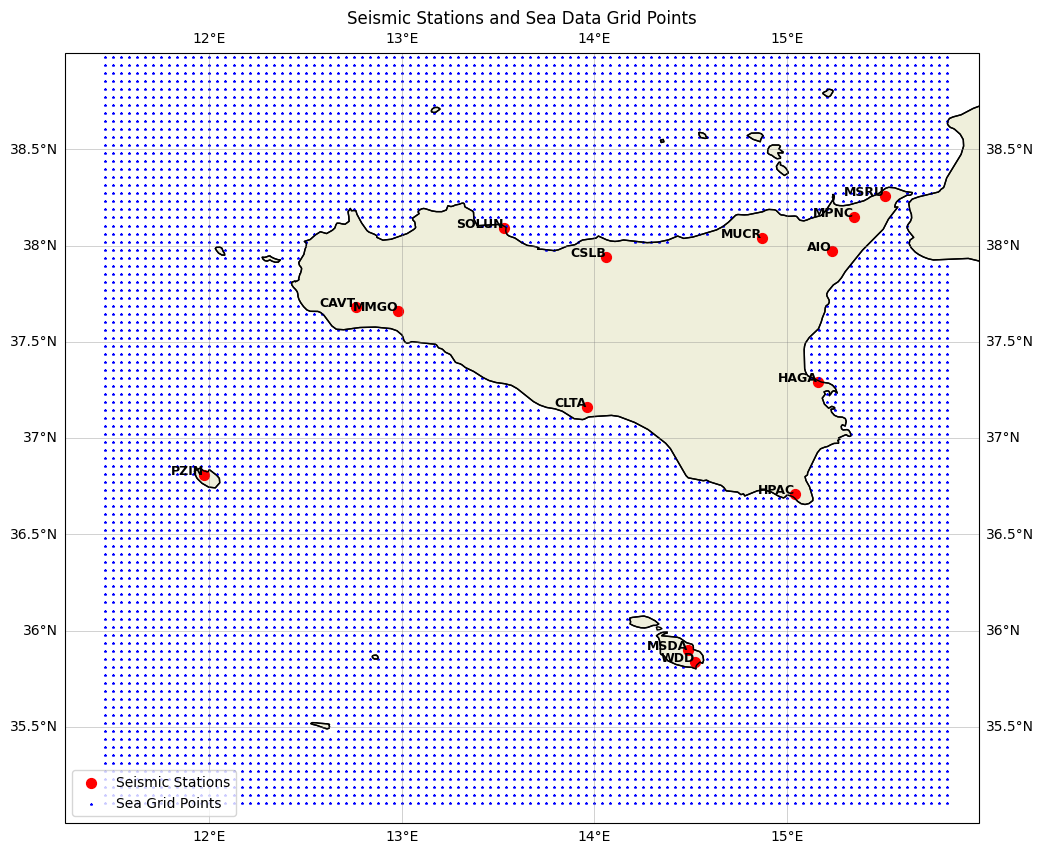

In [18]:
#create the plot
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

#set map extent [west, east, south, north]
ax.set_extent([11.25, 16.0, 35.0, 39.0], crs=ccrs.PlateCarree())

#add land features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

#plot seismic stations
ax.scatter(station_lons, station_lats, color='red', marker='o', s=50, label='Seismic Stations')

#annotate station names
for name, lat, lon in zip(station_names, station_lats, station_lons):
    ax.text(lon, lat, name, fontsize=9, fontweight='bold', ha='right', transform=ccrs.PlateCarree())

#plot grid cell locations
ax.scatter(grid_lons, grid_lats, color='blue', marker='1', s=3, label='Sea Grid Points')

#add a legend
plt.legend()

#add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

plt.title("Seismic Stations and Sea Data Grid Points")
plt.show()

# Find the closest grid points

In [19]:
#define a margin around each station to compute the distance between that station and the surrounding grid points.
#this is done so the distance is not calculated from each station to the 9,000+ grid cells, but rather those reasonably close to it

lat_margin = 0.5
lon_margin = 0.5

#define station coordinates
station_coords = list(zip(station_lats, station_lons))

#define grid coordinates
grid_coords = list(zip(grid_lats, grid_lons))

In [20]:
nearest_grid_points = {}

for station_name, (station_lat, station_lon) in zip(station_names, station_coords):
    #define bounding box around the station
    lat_min = station_lat - lat_margin
    lat_max = station_lat + lat_margin
    lon_min = station_lon - lon_margin
    lon_max = station_lon + lon_margin

    filtered_points = []
    
    #iterate over all grid coordinates
    for lat, lon in grid_coords:
        #check if the grid point is within the latitude and longitude bounds
        is_within_bounding_box = (lat_min <= lat <= lat_max) and (lon_min <= lon <= lon_max)
        
        #if within the ROI, add the point to the filtered list
        if is_within_bounding_box:
            filtered_points.append((lat, lon))

    #compute distances only for the filtered points
    distances = []
    for grid_point in filtered_points:
        distance, _, _ = gps2dist_azimuth(station_lat, station_lon, grid_point[0], grid_point[1])
        distances.append((distance, grid_point))

    #sort by distance and get the nearest 5 points
    distances.sort(key=lambda x: x[0])
    nearest_grid_points[station_name] = [point for _, point in distances[:5]]

In [21]:
for station_name, points in nearest_grid_points.items():
    print(f"Nearest grid points for station {station_name}: {points}")

Nearest grid points for station AIO: [(37.895835876464844, 15.333335876464844), (37.9375, 15.375), (37.895835876464844, 15.375), (37.85416793823242, 15.333335876464844), (37.97916793823242, 15.416667938232422)]
Nearest grid points for station CAVT: [(37.5625, 12.75), (37.5625, 12.791667938232422), (37.5625, 12.708333969116211), (37.5625, 12.833333969116211), (37.5625, 12.666667938232422)]
Nearest grid points for station CLTA: [(37.10416793823242, 13.875), (37.0625, 13.958335876464844), (37.0625, 14.0), (37.0625, 13.916667938232422), (37.10416793823242, 13.833333969116211)]
Nearest grid points for station CSLB: [(38.0625, 14.041667938232422), (38.0625, 14.083335876464844), (38.0625, 14.0), (38.0625, 14.125), (38.020835876464844, 13.916667938232422)]
Nearest grid points for station HAGA: [(37.3125, 15.166667938232422), (37.3125, 15.125), (37.3125, 15.208335876464844), (37.35416793823242, 15.166667938232422), (37.35416793823242, 15.125)]
Nearest grid points for station HPAC: [(36.6875, 15

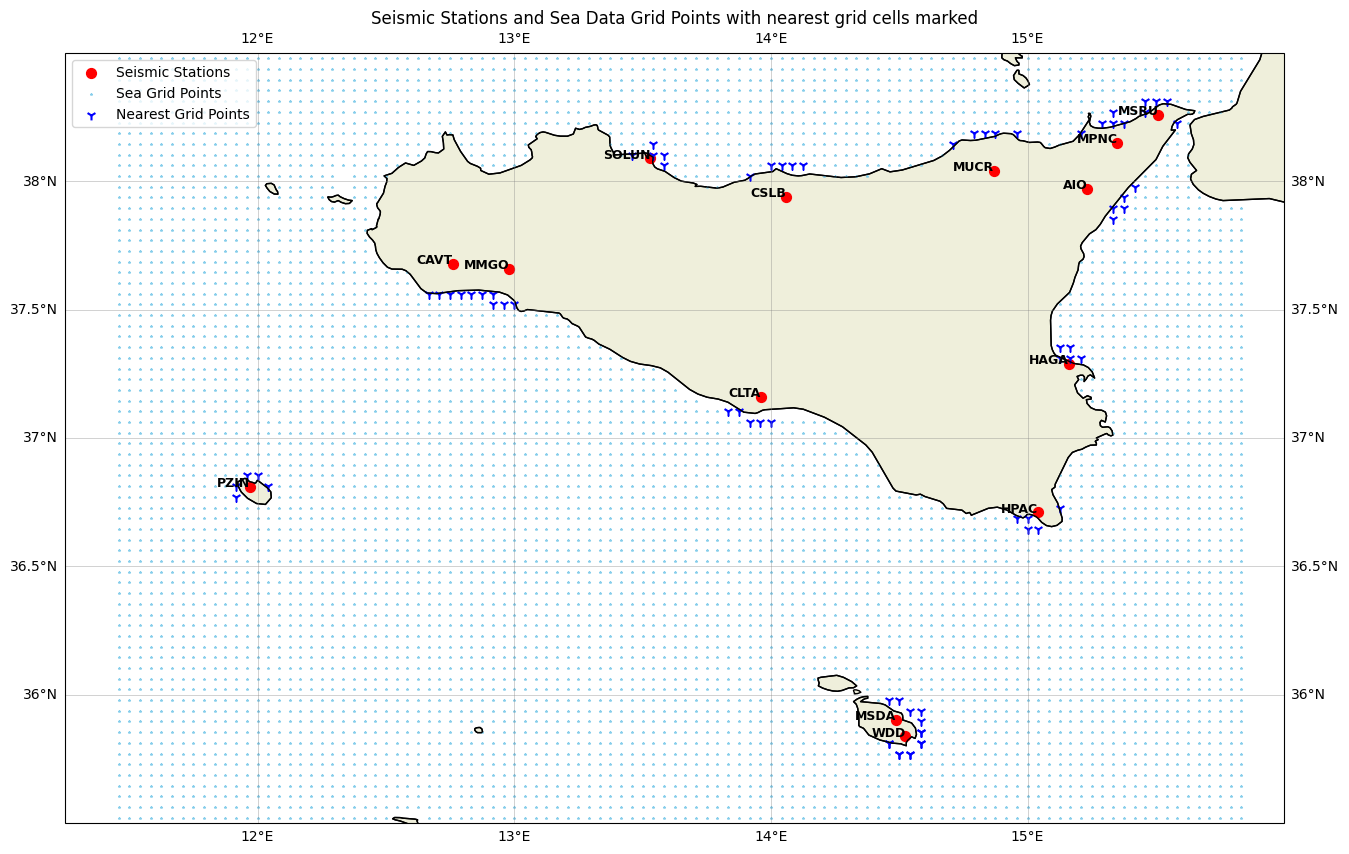

In [22]:
#create the plot
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

#set map extent [west, east, south, north]
ax.set_extent([11.25, 16.0, 35.5, 38.5], crs=ccrs.PlateCarree())

#add land features for better visualization
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

#plot seismic stations
ax.scatter(station_lons, station_lats, color='red', marker='o', s=50, label='Seismic Stations')

#annotate station names
for name, lat, lon in zip(station_names, station_lats, station_lons):
    ax.text(lon, lat, name, fontsize=9, fontweight='bold', ha='right', transform=ccrs.PlateCarree())

#plot grid cell locations
ax.scatter(grid_lons, grid_lats, color='skyblue', marker='1', s=3, label='Sea Grid Points')

#plot nearest grid points for each station-
for station, nearest_points in nearest_grid_points.items():
    #extract the latitudes and longitudes of the nearest points
    nearest_lats, nearest_lons = zip(*nearest_points)
    ax.scatter(nearest_lons, nearest_lats, color='blue', marker='1', s=50)

#mark the label once, outside of thefor loop, so it shows only once in the legend
ax.scatter(nearest_lons, nearest_lats, color='blue', marker='1', s=50, label='Nearest Grid Points')

#add legend
plt.legend()

#add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

plt.title("Seismic Stations and Sea Data Grid Points with nearest grid cells marked")
plt.show()

# Prepare data set for each station

* I/P variables: seismic data
* Target variables: SWH at the 5 nearest grid cells, mean, mode and median of the 5 data points

In [23]:
#Function to combine data from rms and sea of nearest grid points to that station at every timestamp
def create_station_sea_rms_df(station, rms_data, sea_data, nearest_grid_points):
    #get the corresponding grid points for the station
    grid_points = nearest_grid_points[station]
    
    #extract the columns from SEA_data based on the grid points
    sea_columns = [f"({lat}, {lon})" for lat, lon in grid_points]
    
    #extract RMS data for the current station 
    rms_columns = [col for col in rms_data.columns if col.startswith(station)]
    rms_values = rms_data[rms_columns]
    #print(rms_values)

    #create the dataframe with timestamp (index), RMS value and corresponding sea data columns
    result = pd.DataFrame(index=rms_data['index//'])
    for col in rms_columns:
        result[col] = rms_values[col].values
    for col in sea_columns:
        result[col] = sea_data[col].values

    #compute mean median and mode for each row
    result['sea_mean'] = result[sea_columns].mean(axis=1)
    result['sea_median'] = result[sea_columns].median(axis=1)
    result['sea_mode'] = result[sea_columns].mode(axis=1)[0]  #if the mode returns multiple values, take the first one
    
    return result

In [24]:
#create a dictionary to store all the dataframes (one for each station)
stations_sea_rms = {}

for station in station_names:
    print(station)
    stations_sea_rms[station] = create_station_sea_rms_df(station, df_rms, df_sea, nearest_grid_points)

AIO
CAVT
CLTA
CSLB
HAGA
HPAC
MMGO
MPNC
MSDA
MSRU
MUCR
PZIN
SOLUN
WDD


In [25]:
stations_sea_rms['AIO']

AIO/Z/0.05-0.2  AIO/Z/0.2-0.35  AIO/Z/0.35-0.5  \
index//                                                                     
2018-01-01 00:00:00+00:00    8.962463e-08    9.570469e-08    4.395065e-08   
2018-01-01 01:00:00+00:00    9.139982e-08    9.545442e-08    4.554082e-08   
2018-01-01 02:00:00+00:00    9.439162e-08    9.012828e-08    4.710841e-08   
2018-01-01 03:00:00+00:00    8.867206e-08    8.623706e-08    4.320707e-08   
2018-01-01 04:00:00+00:00    8.916084e-08    8.286553e-08    4.656767e-08   
...                                   ...             ...             ...   
2021-12-31 19:00:00+00:00    9.568344e-08    9.465563e-08    6.906840e-08   
2021-12-31 20:00:00+00:00    9.305131e-08    9.417616e-08    6.996478e-08   
2021-12-31 21:00:00+00:00    9.581524e-08    8.994636e-08    6.428183e-08   
2021-12-31 22:00:00+00:00    9.660791e-08    8.820693e-08    6.564504e-08   
2021-12-31 23:00:00+00:00    9.894424e-08    9.338617e-08    7.067455e-08   

                           AIO/Z/0.5-0.65  AIO/Z/0.65-0.8  AIO/Z/0.8-0.95  \
index//                                                                     
2018-01-01 00:00:00+00:00    2.635211e-08    1.504294e-08    1.228466e-08   
2018-01-01 01:00:00+00:00    2.739944e-08    1.617472e-08    1.297614e-08   
2018-01-01 02:00:00+00:00    2.778390e-08    1.679221e-08    1.309314e-08   
2018-01-01 03:00:00+00:00    2.511082e-08    1.597771e-08    1.260992e-08   
2018-01-01 04:00:00+00:00    2.596107e-08    1.598942e-08    1.339003e-08   
...                                   ...             ...             ...   
2021-12-31 19:00:00+00:00    4.191455e-08    2.063108e-08    1.223949e-08   
2021-12-31 20:00:00+00:00    3.858088e-08    1.823494e-08    1.221914e-08   
2021-12-31 21:00:00+00:00    3.625617e-08    1.793131e-08    1.181989e-08   
2021-12-31 22:00:00+00:00    3.429514e-08    1.858419e-08    1.171665e-08   
2021-12-31 23:00:00+00:00    3.748581e-08    1.762177e-08    1.148989e-08   

                           AIO/Z/0.95-1.1  AIO/Z/1.1-1.25  AIO/Z/1.25-1.4  \
index//                                                                     
2018-01-01 00:00:00+00:00    1.170398e-08    7.072696e-09    4.951798e-09   
2018-01-01 01:00:00+00:00    1.296917e-08    6.846057e-09    4.983450e-09   
2018-01-01 02:00:00+00:00    1.231415e-08    7.251900e-09    4.827073e-09   
2018-01-01 03:00:00+00:00    1.154924e-08    6.421025e-09    4.593370e-09   
2018-01-01 04:00:00+00:00    1.128488e-08    7.107042e-09    4.528138e-09   
...                                   ...             ...             ...   
2021-12-31 19:00:00+00:00    8.252051e-09    5.771018e-09    3.934249e-09   
2021-12-31 20:00:00+00:00    7.779101e-09    5.495682e-09    3.958890e-09   
2021-12-31 21:00:00+00:00    8.348819e-09    5.808163e-09    4.026388e-09   
2021-12-31 22:00:00+00:00    7.836042e-09    5.283066e-09    3.844381e-09   
2021-12-31 23:00:00+00:00    8.087430e-09    5.666756e-09    4.113585e-09   

                           AIO/Z/1.4-1.55  ...  AIO/E/1.7-1.85  \
index//                                    ...                   
2018-01-01 00:00:00+00:00    3.367684e-09  ...    3.015038e-09   
2018-01-01 01:00:00+00:00    3.455066e-09  ...    3.036236e-09   
2018-01-01 02:00:00+00:00    3.473249e-09  ...    3.251087e-09   
2018-01-01 03:00:00+00:00    3.224326e-09  ...    2.949792e-09   
2018-01-01 04:00:00+00:00    3.272456e-09  ...    2.809070e-09   
...                                   ...  ...             ...   
2021-12-31 19:00:00+00:00    3.015207e-09  ...    2.460845e-09   
2021-12-31 20:00:00+00:00    2.757386e-09  ...    2.348559e-09   
2021-12-31 21:00:00+00:00    2.900551e-09  ...    2.275696e-09   
2021-12-31 22:00:00+00:00    2.740935e-09  ...    2.473858e-09   
2021-12-31 23:00:00+00:00    2.920235e-09  ...    2.413242e-09   

                           AIO/E/1.85-2.0  \
index//                                     
2018-01-01 00:00:00+00:00    3.282874e-09   
2018-01-01 01:00:00+00:00  

# Find the longest continuous streak without NaNs

In [26]:
def longest_non_nan_streak_tolerance(df, interpolation_tolerance, colnum):
    
    mask = df.iloc[:, colnum].isna().astype(int) #1: NaN; 0: not NaN
    
    max_length = 0
    max_start = None
    max_end = None

    current_length = 0
    current_start = None
    nan_count = 0
    found_first_valid = False #to ensure that if the data set starts with NaNs, the last NaNs within the tolerance range are not included in the "to consider" part of the data

    i = 0
    while i < len(mask):
        if mask.iloc[i] == 0: #found a non-NaN value
            if not found_first_valid:  
                found_first_valid = True
                current_start = df.index[i]
                current_length = 1 #start counting
            else:
                current_length += 1 #continue the valid stretch
            nan_count = 0  #reset NaN counter
        else: #encountered NaN
            nan_count += 1
            if found_first_valid and nan_count <= interpolation_tolerance:
                current_length += 1 #allow within tolerance
            else:
                #if tolerance exceeded or we haven't found a valid start, reset
                if current_length > max_length:
                    max_length = current_length - interpolation_tolerance
                    max_start = current_start
                    max_start_idx = df.index.get_loc(max_start)
                    max_end = df.index[max_start_idx + max_length -1]
                
                #reset tracking variables
                found_first_valid = False
                current_length = 0
                nan_count = 0

        i += 1  #move to the next index

    #Edge case: If the longest stretch is at the end of the DataFrame
    if current_length > max_length:
        max_length = current_length
        max_start = current_start
        max_end = df.index[-1]

    return max_start, max_end, max_length

In [27]:
longest_streak = [['station','colname','start','end','count']] #array to store data

interpolation_tolerance = 8

for station in station_names:
    df = stations_sea_rms[station]
    for colnum in range(len(df.columns)):
        start, end, count = longest_non_nan_streak_tolerance(df, interpolation_tolerance, colnum)
        colname = df.columns[colnum]
        longest_streak.append([station, colname, start, end, count])

In [28]:
longest_streakdf = pd.DataFrame(longest_streak)
longest_streakdf

0                                         1  \
0    station                                   colname   
1        AIO                            AIO/Z/0.05-0.2   
2        AIO                            AIO/Z/0.2-0.35   
3        AIO                            AIO/Z/0.35-0.5   
4        AIO                            AIO/Z/0.5-0.65   
..       ...                                       ...   
654      WDD  (35.770835876464844, 14.541667938232422)   
655      WDD                (35.770835876464844, 14.5)   
656      WDD                                  sea_mean   
657      WDD                                sea_median   
658      WDD                                  sea_mode   

                             2                          3      4  
0                        start                        end  count  
1    2019-04-24 01:00:00+00:00  2020-12-06 12:00:00+00:00  14220  
2    2019-04-24 01:00:00+00:00  2020-12-06 12:00:00+00:00  14220  
3    2019-04-24 01:00:00+00:00  2020-12-06 12:00:00+00:00  14220  
4    2019-04-24 01:00:00+00:00  2020-12-06 12:00:00+00:00  14220  
..                         ...                        ...    ...  
654  2018-01-01 00:00:00+00:00  2021-12-31 23:00:00+00:00  35064  
655  2018-01-01 00:00:00+00:00  2021-12-31 23:00:00+00:00  35064  
656  2018-01-01 00:00:00+00:00  2021-12-31 23:00:00+00:00  35064  
657  2018-01-01 00:00:00+00:00  2021-12-31 23:00:00+00:00  35064  
658  2018-01-01 00:00:00+00:00  2021-12-31 23:00:00+00:00  35064  

[659 rows x 5 columns]

In [29]:
#longest_streakdf.to_csv('nan tolerance analysis/nan analysis - tolerance 8.csv', index=False, header=False)

In [30]:
#Analyse and obtain the ideal consistent start date for each station at various tolerances.
#At times, the number my vary by a small number of hours (eg. 2 or 3 hours) for different frequency bands
#In this case, the common time period across all frequency bands is taken.
#NB: This analysis was carried out manually by inspecting the generated csv files

data = [
    #results for tolerance level of 0 data points to interpolate
    ['AIO', 0, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 0, '2018-01-01 00:00:00+00:00', '2018-09-20 17:00:00+00:00', 6306],
    ['CLTA', 0, '2018-10-12 13:00:00+00:00', '2019-08-28 23:00:00+00:00', 7691],
    ['CSLB', 0, '2020-09-14 07:00:00+00:00', '2021-05-24 16:00:00+00:00', 6058],
    ['HAGA', 0, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 0, '2018-03-25 15:00:00+00:00', '2018-10-14 18:00:00+00:00', 4876],
    ['MMGO', 0, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 0, '2019-04-20 01:00:00+00:00', '2019-11-11 22:00:00+00:00', 4942],
    ['MSDA', 0, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 0, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 0, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 0, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 0, '2019-07-18 01:00:00+00:00', '2020-02-08 11:00:00+00:00', 4931],
    ['WDD', 0, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421],

    #results for tolerance level of 1 data point to interpolate
    ['AIO', 1, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 1, '2019-06-24 08:00:00+00:00', '2020-03-20 23:00:00+00:00', 6496],
    ['CLTA', 1, '2018-10-12 13:00:00+00:00', '2019-08-28 23:00:00+00:00', 7691],
    ['CSLB', 1, '2020-09-14 07:00:00+00:00', '2021-05-24 16:00:00+00:00', 6058],
    ['HAGA', 1, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 1, '2018-03-25 15:00:00+00:00', '2018-10-14 18:00:00+00:00', 4876],
    ['MMGO', 1, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 1, '2019-04-20 01:00:00+00:00', '2019-11-11 22:00:00+00:00', 4942],
    ['MSDA', 1, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 1, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 1, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 1, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 1, '2020-10-29 10:00:00+00:00', '2021-10-14 23:00:00+00:00', 8414],
    ['WDD', 1, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421],

    #results for tolerance level of 2 data points to interpolate
    ['AIO', 2, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 2, '2019-06-24 08:00:00+00:00', '2020-03-20 23:00:00+00:00', 6496],
    ['CLTA', 2, '2018-10-12 13:00:00+00:00', '2019-08-28 23:00:00+00:00', 7691],
    ['CSLB', 2, '2020-09-14 07:00:00+00:00', '2021-05-24 16:00:00+00:00', 6058],
    ['HAGA', 2, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 2, '2018-03-25 15:00:00+00:00', '2018-10-14 18:00:00+00:00', 4876],
    ['MMGO', 2, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 2, '2019-04-20 01:00:00+00:00', '2019-12-24 21:00:00+00:00', 5973],
    ['MSDA', 2, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 2, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 2, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 2, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 2, '2020-10-29 10:00:00+00:00', '2021-10-14 23:00:00+00:00', 8414],
    ['WDD', 2, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421],

    #results for tolerance level of 3 data points to interpolate
    ['AIO', 3, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 3, '2019-06-24 08:00:00+00:00', '2020-03-20 23:00:00+00:00', 6496],
    ['CLTA', 3, '2018-10-12 13:00:00+00:00', '2019-08-28 23:00:00+00:00', 7691],
    ['CSLB', 3, '2020-09-14 07:00:00+00:00', '2021-05-24 16:00:00+00:00', 6058],
    ['HAGA', 3, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 3, '2018-03-25 15:00:00+00:00', '2018-10-14 18:00:00+00:00', 4876],
    ['MMGO', 3, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 3, '2019-04-20 01:00:00+00:00', '2019-12-24 21:00:00+00:00', 5973],
    ['MSDA', 3, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 3, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 3, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 3, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 3, '2020-10-29 10:00:00+00:00', '2021-10-14 23:00:00+00:00', 8414],
    ['WDD', 3, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421],

    #results for tolerance level of 4 data points to interpolate
    ['AIO', 4, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 4, '2019-06-24 08:00:00+00:00', '2020-03-20 23:00:00+00:00', 6496],
    ['CLTA', 4, '2018-10-12 13:00:00+00:00', '2019-08-28 23:00:00+00:00', 7691],
    ['CSLB', 4, '2020-09-14 07:00:00+00:00', '2021-05-24 16:00:00+00:00', 6058],
    ['HAGA', 4, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 4, '2018-03-25 15:00:00+00:00', '2018-10-14 18:00:00+00:00', 4876],
    ['MMGO', 4, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 4, '2019-04-20 01:00:00+00:00', '2019-12-24 21:00:00+00:00', 5973],
    ['MSDA', 4, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 4, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 4, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 4, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 4, '2020-10-29 10:00:00+00:00', '2021-10-14 23:00:00+00:00', 8414],
    ['WDD', 4, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421],

    #results for tolerance level of 5 data points to interpolate
    ['AIO', 5, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 5, '2019-06-24 08:00:00+00:00', '2020-03-20 23:00:00+00:00', 6496],
    ['CLTA', 5, '2018-10-12 13:00:00+00:00', '2019-08-28 23:00:00+00:00', 7691],
    ['CSLB', 5, '2020-09-14 07:00:00+00:00', '2021-05-24 16:00:00+00:00', 6058],
    ['HAGA', 5, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 5, '2018-03-25 15:00:00+00:00', '2018-10-14 18:00:00+00:00', 4876],
    ['MMGO', 5, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 5, '2019-04-20 01:00:00+00:00', '2019-12-24 21:00:00+00:00', 5973],
    ['MSDA', 5, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 5, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 5, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 5, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 5, '2020-10-29 10:00:00+00:00', '2021-10-14 23:00:00+00:00', 8414],
    ['WDD', 5, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421],

    #results for tolerance level of 6 data points to interpolate
    ['AIO', 6, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 6, '2019-06-24 08:00:00+00:00', '2020-03-20 23:00:00+00:00', 6496],
    ['CLTA', 6, '2018-10-12 13:00:00+00:00', '2019-08-28 23:00:00+00:00', 7691],
    ['CSLB', 6, '2020-09-14 07:00:00+00:00', '2021-05-24 16:00:00+00:00', 6058],
    ['HAGA', 6, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 6, '2018-03-25 15:00:00+00:00', '2018-10-14 18:00:00+00:00', 4876],
    ['MMGO', 6, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 6, '2019-04-20 01:00:00+00:00', '2019-12-24 21:00:00+00:00', 5973],
    ['MSDA', 6, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 6, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 6, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 6, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 6, '2020-10-29 10:00:00+00:00', '2021-10-14 23:00:00+00:00', 8414],
    ['WDD', 6, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421],

    #results for tolerance level of 7 data points to interpolate
    ['AIO', 7, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 7, '2019-06-24 08:00:00+00:00', '2020-04-16 21:00:00+00:00', 7142],
    ['CLTA', 7, '2018-10-12 13:00:00+00:00', '2019-08-28 23:00:00+00:00', 7691],
    ['CSLB', 7, '2020-09-14 07:00:00+00:00', '2021-05-24 16:00:00+00:00', 6058],
    ['HAGA', 7, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 7, '2018-03-25 15:00:00+00:00', '2018-10-14 18:00:00+00:00', 4876],
    ['MMGO', 7, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 7, '2019-04-20 01:00:00+00:00', '2019-12-24 21:00:00+00:00', 5973],
    ['MSDA', 7, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 7, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 7, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 7, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 7, '2020-10-29 10:00:00+00:00', '2021-10-14 23:00:00+00:00', 8414],
    ['WDD', 7, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421],

    #results for tolerance level of 8 data points to interpolate
    ['AIO', 8, '2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00', 14217],
    ['CAVT', 8, '2019-06-24 08:00:00+00:00', '2020-10-03 00:00:00+00:00', 11201],
    ['CLTA', 8, '2019-11-21 11:00:00+00:00', '2020-10-11 22:00:00+00:00', 7812],
    ['CSLB', 8, '2019-08-09 08:00:00+00:00', '2020-09-13 19:00:00+00:00', 9636],
    ['HAGA', 8, '2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00', 13720],
    ['HPAC', 8, '2018-11-02 06:00:00+00:00', '2019-07-01 11:00:00+00:00', 5790],
    ['MMGO', 8, '2019-12-05 06:00:00+00:00', '2020-11-05 07:00:00+00:00', 8066],
    ['MPNC', 8, '2019-04-20 01:00:00+00:00', '2019-12-24 21:00:00+00:00', 5973],
    ['MSDA', 8, '2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00', 15686],
    ['MSRU', 8, '2019-04-24 05:00:00+00:00', '2019-11-17 21:00:00+00:00', 4985],
    ['MUCR', 8, '2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00', 19376],
    ['PZIN', 8, '2021-12-06 14:00:00+00:00', '2021-12-31 23:00:00+00:00', 610],
    ['SOLUN', 8, '2020-10-29 10:00:00+00:00', '2021-10-14 23:00:00+00:00', 8414],
    ['WDD', 8, '2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00', 9421]
]

columns = ['station', 'nan_tolerance', 'start_date', 'end_date', 'num_data_pts']

nan_tolerance_df = pd.DataFrame(data, columns=columns)

nan_tolerance_df['data_pts_yrs'] = nan_tolerance_df['num_data_pts'].astype(float) / (24*365)

nan_tolerance_df

station  nan_tolerance                 start_date  \
0       AIO              0  2019-04-24 04:00:00+00:00   
1      CAVT              0  2018-01-01 00:00:00+00:00   
2      CLTA              0  2018-10-12 13:00:00+00:00   
3      CSLB              0  2020-09-14 07:00:00+00:00   
4      HAGA              0  2019-02-18 01:00:00+00:00   
..      ...            ...                        ...   
121    MSRU              8  2019-04-24 05:00:00+00:00   
122    MUCR              8  2019-05-17 02:00:00+00:00   
123    PZIN              8  2021-12-06 14:00:00+00:00   
124   SOLUN              8  2020-10-29 10:00:00+00:00   
125     WDD              8  2018-05-21 12:00:00+00:00   

                      end_date  num_data_pts  data_pts_yrs  
0    2020-12-06 12:00:00+00:00         14217      1.622945  
1    2018-09-20 17:00:00+00:00          6306      0.719863  
2    2019-08-28 23:00:00+00:00          7691      0.877968  
3    2021-05-24 16:00:00+00:00          6058      0.691553  
4    2020-09-11 16:00:00+00:00         13720      1.566210  
..                         ...           ...           ...  
121  2019-11-17 21:00:00+00:00          4985      0.569064  
122  2021-08-01 09:00:00+00:00         19376      2.211872  
123  2021-12-31 23:00:00+00:00           610      0.069635  
124  2021-10-14 23:00:00+00:00          8414      0.960502  
125  2019-06-18 00:00:00+00:00          9421      1.075457  

[126 rows x 6 columns]

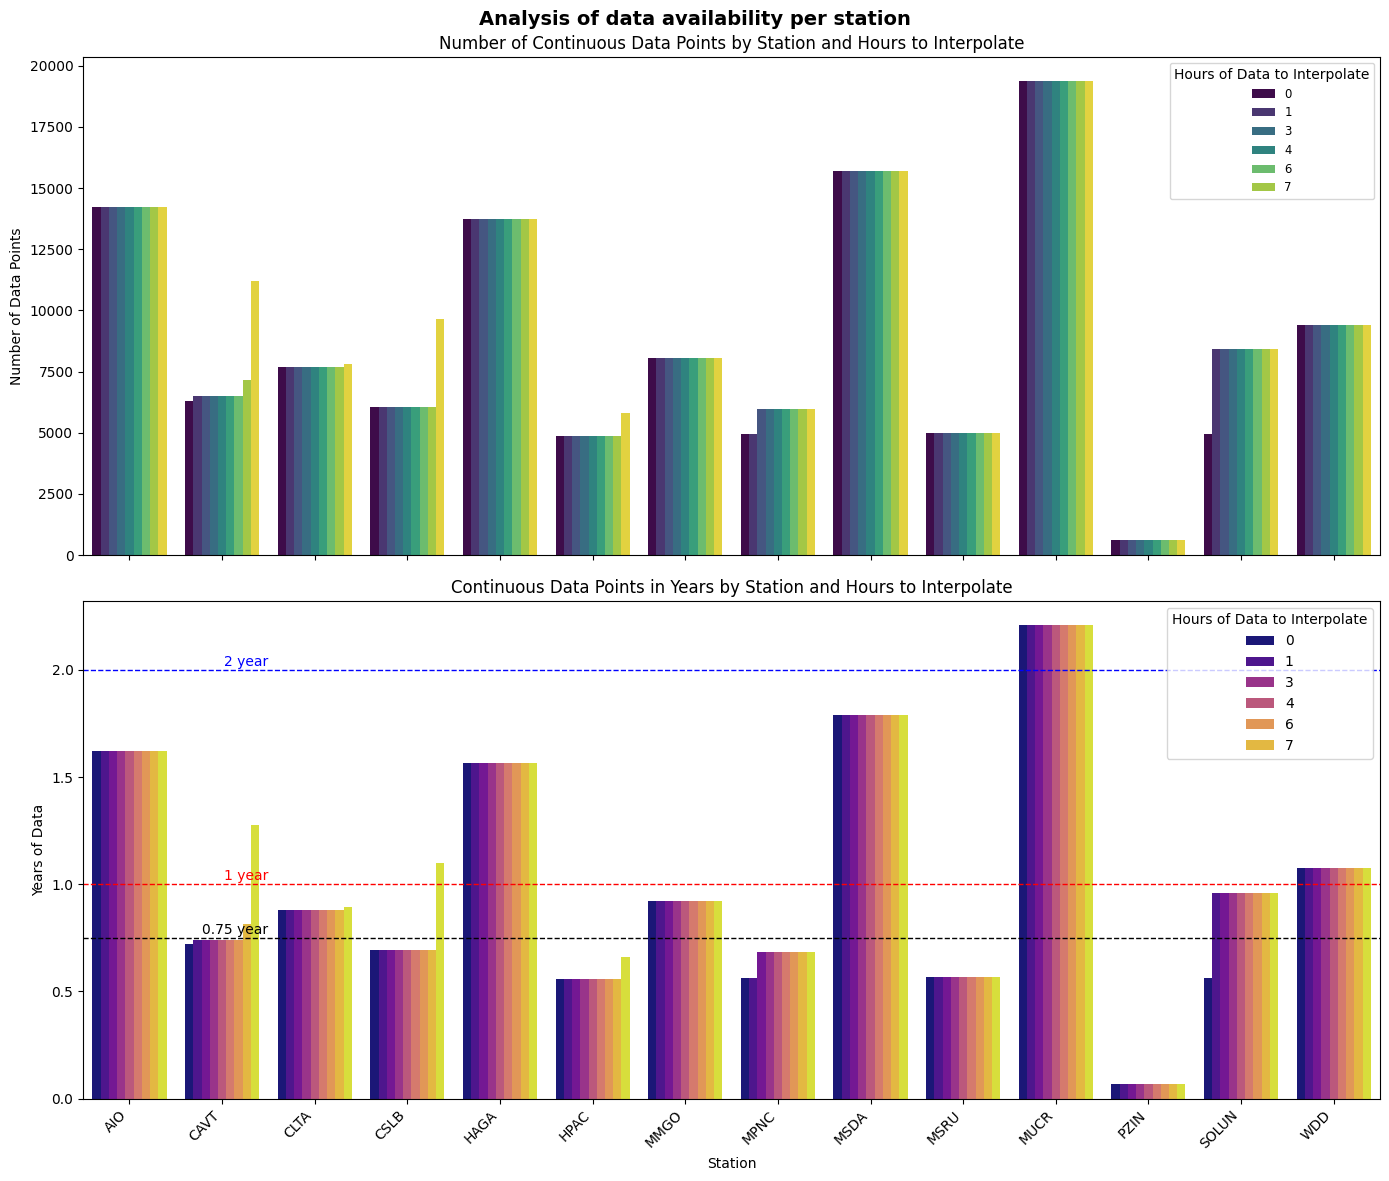

In [38]:
#two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), sharex=True)

fig.suptitle("Analysis of data availability per station", fontsize=14, fontweight="bold")

#plot 1: Number of Data Points
sns.barplot(
    data=nan_tolerance_df,
    x="station",
    y="num_data_pts",
    hue="nan_tolerance",
    ax=axes[0],
    palette="viridis"
)
axes[0].set_title("Number of Continuous Data Points by Station and Hours to Interpolate")
axes[0].set_ylabel("Number of Data Points")
axes[0].legend(title="Hours of Data to Interpolate", fontsize='small')

#plot 2: Data Points in Years
sns.barplot(
    data=nan_tolerance_df,
    x="station",
    y="data_pts_yrs",
    hue="nan_tolerance",
    ax=axes[1],
    palette="plasma"
)
axes[1].set_title("Continuous Data Points in Years by Station and Hours to Interpolate")
axes[1].set_ylabel("Years of Data")
axes[1].legend(title="Hours of Data to Interpolate")

#add horizontal lines for 1-year and 2-year thresholds
axes[1].axhline(y=1.0, color="red", linestyle="--", linewidth=1)
axes[1].axhline(y=2.0, color="blue", linestyle="--", linewidth=1)
axes[1].axhline(y=0.75, color="black", linestyle="--", linewidth=1)

axes[1].text(1.5, 1.02, "1 year", color="red", fontsize=10, ha="right")
axes[1].text(1.5, 2.02, "2 year", color="blue", fontsize=10, ha="right")
axes[1].text(1.5, 0.77, "0.75 year", color="black", fontsize=10, ha="right")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Station")
plt.tight_layout()
plt.show()

# Create the final data set

Keeping only the stations with at least one year of data: AIO, CAVT, CSLB, HAGA, MSDA, MUCR, WDD

And applying linear interpolation for any gaps.

In [39]:
#Final station names and time ranges
station_time_ranges = {
    'AIO': ['2019-04-24 04:00:00+00:00', '2020-12-06 12:00:00+00:00'],
    'CAVT': ['2019-06-24 08:00:00+00:00', '2020-10-03 00:00:00+00:00'],
    'CSLB': ['2019-08-09 08:00:00+00:00', '2020-09-13 19:00:00+00:00'],
    'HAGA': ['2019-02-18 01:00:00+00:00', '2020-09-11 16:00:00+00:00'],
    'MSDA': ['2019-12-15 22:00:00+00:00', '2021-09-29 11:00:00+00:00'],
    'MUCR': ['2019-05-17 02:00:00+00:00', '2021-08-01 09:00:00+00:00'],
    'WDD': ['2018-05-21 12:00:00+00:00', '2019-06-18 00:00:00+00:00']
}

In [48]:
#store filtered and interpolated data
filtered_stations = {}

for station, (start_time, end_time) in station_time_ranges.items():
    if station in stations_sea_rms:
        df = stations_sea_rms[station].copy()
        
        df.index.name = 'index'
        df = df.loc[start_time:end_time]
        
        #filter data within the time range
        df = df.loc[start_time:end_time]
        
        #apply linear interpolation to fill gaps
        df = df.interpolate(method='linear')
        
        #store the processed dataframe
        filtered_stations[station] = df

In [49]:
filtered_stations['AIO']

AIO/Z/0.05-0.2  AIO/Z/0.2-0.35  AIO/Z/0.35-0.5  \
index                                                                       
2019-04-24 04:00:00+00:00    1.824723e-07    3.137415e-07    8.854606e-08   
2019-04-24 05:00:00+00:00    1.747832e-07    3.188403e-07    8.655483e-08   
2019-04-24 06:00:00+00:00    1.666332e-07    2.968048e-07    9.132062e-08   
2019-04-24 07:00:00+00:00    1.500549e-07    2.849639e-07    8.553900e-08   
2019-04-24 08:00:00+00:00    1.334893e-07    2.613291e-07    8.599661e-08   
...                                   ...             ...             ...   
2020-12-06 08:00:00+00:00    2.206248e-07    6.554637e-07    2.611246e-07   
2020-12-06 09:00:00+00:00    2.501811e-07    7.032051e-07    2.543645e-07   
2020-12-06 10:00:00+00:00    2.325877e-07    6.551033e-07    2.506454e-07   
2020-12-06 11:00:00+00:00    2.292215e-07    6.570205e-07    2.374503e-07   
2020-12-06 12:00:00+00:00    1.979437e-07    5.849101e-07    2.270255e-07   

                           AIO/Z/0.5-0.65  AIO/Z/0.65-0.8  AIO/Z/0.8-0.95  \
index                                                                       
2019-04-24 04:00:00+00:00    4.697557e-08    3.017240e-08    2.067881e-08   
2019-04-24 05:00:00+00:00    5.097345e-08    3.023044e-08    2.117730e-08   
2019-04-24 06:00:00+00:00    5.221213e-08    3.150088e-08    2.038838e-08   
2019-04-24 07:00:00+00:00    5.325268e-08    3.096282e-08    2.013371e-08   
2019-04-24 08:00:00+00:00    5.175733e-08    3.063121e-08    2.063498e-08   
...                                   ...             ...             ...   
2020-12-06 08:00:00+00:00    1.312566e-07    7.015610e-08    4.534051e-08   
2020-12-06 09:00:00+00:00    1.316964e-07    7.348396e-08    4.654214e-08   
2020-12-06 10:00:00+00:00    1.324700e-07    7.303139e-08    4.798142e-08   
2020-12-06 11:00:00+00:00    1.247681e-07    7.121705e-08    4.514365e-08   
2020-12-06 12:00:00+00:00    1.219400e-07    6.565337e-08    4.383969e-08   

                           AIO/Z/0.95-1.1  AIO/Z/1.1-1.25  AIO/Z/1.25-1.4  \
index                                                                       
2019-04-24 04:00:00+00:00    1.636368e-08    1.035425e-08    8.378898e-09   
2019-04-24 05:00:00+00:00    1.624665e-08    1.036566e-08    8.550918e-09   
2019-04-24 06:00:00+00:00    1.587732e-08    1.065436e-08    8.334643e-09   
2019-04-24 07:00:00+00:00    1.597850e-08    1.009984e-08    7.635221e-09   
2019-04-24 08:00:00+00:00    1.577028e-08    1.003101e-08    7.811064e-09   
...                                   ...             ...             ...   
2020-12-06 08:00:00+00:00    2.995948e-08    2.061861e-08    1.661342e-08   
2020-12-06 09:00:00+00:00    3.220711e-08    2.168085e-08    1.709557e-08   
2020-12-06 10:00:00+00:00    3.281178e-08    2.195330e-08    1.739600e-08   
2020-12-06 11:00:00+00:00    3.066930e-08    2.058492e-08    1.687978e-08   
2020-12-06 12:00:00+00:00    2.893385e-08    2.087221e-08    1.622959e-08   

                           AIO/Z/1.4-1.55  ...  AIO/E/1.7-1.85  \
index                                      ...                   
2019-04-24 04:00:00+00:00    6.000831e-09  ...    6.333105e-09   
2019-04-24 05:00:00+00:00    5.693879e-09  ...    5.965676e-09   
2019-04-24 06:00:00+00:00    5.537322e-09  ...    5.857008e-09   
2019-04-24 07:00:00+00:00    5.361969e-09  ...    5.190736e-09   
2019-04-24 08:00:00+00:00    5.016690e-09  ...    5.189029e-09   
...                                   ...  ...             ...   
2020-12-06 08:00:00+00:00    1.258767e-08  ...    1.233658e-08   
2020-12-06 09:00:00+00:00    1.338035e-08  ...    1.264850e-08   
2020-12-06 10:00:00+00:00    1.425420e-08  ...    1.309736e-08   
2020-12-06 11:00:00+00:00    1.339658e-08  ...    1.311647e-08   
2020-12-06 12:00:00+00:00    1.212755e-08  ...    1.321642e-08   

                           AIO/E/1.85-2.0  \
index                                       
2019-04-24 04:00:00+00:00    5.706766e-09   
2019-04-24 05:00:00+00:00  

In [53]:
#save data in separate parquet files for each station
for station, df in filtered_stations.items():
    df.to_parquet(f"Processed Data/15.03.2025 Data/{station}.parquet", engine="pyarrow")